## Importing libraries

In [1]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import statistics
from torch import Tensor
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

## Hyperparameters

In [2]:
learning_rate = 0.0005
batch_size = 16
num_epochs = 100

dataset_mean = [0.76458206, 0.60492328, 0.7896577]  
dataset_std = [0.18823201, 0.24406966, 0.14710178] 

torch.manual_seed(43)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is', device)

The current processor is cuda


## Retrieving the data

In [3]:
!conda install -y gdown

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    faiss-proc-1.0.0           |             cuda          18 KB  conda-forge
    filelock-3.12.0            |     pyhd8ed1ab_0          14 KB  conda-forge
    gdown-4.7.1                |     pyhd8ed1ab_0          19 KB  conda-forge
    openssl-1.1.1t             |       h0b41bf4_0         1.9 MB  conda-forge
    ------------------------------------------------------------
               

In [4]:
!gdown --id 14FrjjyPxz3pblmWybQOgDqSZ9z9skutX
!gdown --id 1crE5j10SbXXnAo4vDu1sTljIdFhf5xna

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=14FrjjyPxz3pblmWybQOgDqSZ9z9skutX
From (redirected): https://drive.google.com/uc?id=14FrjjyPxz3pblmWybQOgDqSZ9z9skutX&confirm=t&uuid=74a9e825-9fbd-4141-af06-b67d425bff18
To: /kaggle/working/images.npy
100%|████████████████████████████████████████| 979M/979M [00:22<00:00, 44.4MB/s]
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From (uriginal): https://drive.google.com/uc?id=1crE5j10SbXXnAo4vDu1sTljIdFhf5xna
From (redirected): https://drive.google.com/uc?id=1crE5j10SbXXnAo4vDu1sTljIdFhf5xna&confirm=t&uuid=15f003c2-b0

In [5]:
images = np.load('/kaggle/working/images.npy')
labels = np.load('/kaggle/working/labels.npy')

In [6]:
seg_map = labels[..., 1]

## Plotting the data

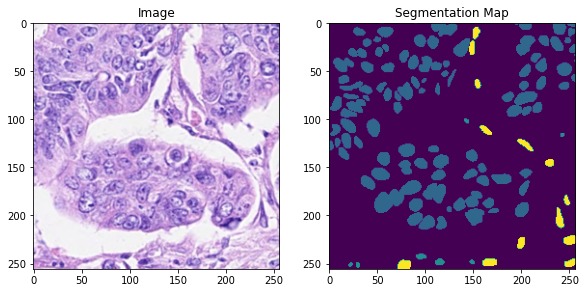

In [7]:
def plot_images(id):
  # rand_id = 103
  viz_dict = {"Image": images[id], "Segmentation Map": seg_map[id]}

  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.title(i)
    plt.axis("on")
    count += 1

def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

plot_images(1)

## Transformation parameters

In [8]:
input_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ]
)

targets_transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0), 255, 1))
    ]
)

## Transforming images and labels

In [9]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    self.data = data
    self.targets = targets

    self.transform = transform
    self.target_transform = target_transform
    
  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]
        
    if self.transform:
      x = self.data[index].astype(np.uint8)
      x = self.transform(x)
      
    if self.target_transform:
      y = self.targets[index].astype(np.uint8)
      y = Image.fromarray(y)
      y = self.target_transform(y).to(torch.long)

    return x, y
    
  def __len__(self):
    return len(self.data)

X_train, X_test, y_train, y_test = train_test_split(images, seg_map,
                                                    test_size=0.20,
                                                    random_state=33)

train_dataset = MyDataset(X_train, y_train, transform=input_transform, target_transform=targets_transform)

test_dataset = MyDataset(X_test, y_test, transform=input_transform, target_transform=targets_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-mc_m1fbw
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-mc_m1fbw
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=3741701 sha256=a9f1d3dfaeb91d890378153c37aed85966d2d1319501fa05230f12779e935cf1
  Stored in directory: /tmp/pip-ephem-wheel-cache-19o_24pw/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


In [11]:
import numpy as np
import pydensecrf.densecrf as dcrf

class CRF(nn.Module):
    def __init__(self, num_iterations=5):
        super(CRF, self).__init__()
        self.num_iterations = num_iterations

    def forward(self, image, mask):
        # Convert image and mask to numpy arrays
        image_np = image.detach().cpu().numpy().squeeze()
        mask_np = mask.detach().cpu().numpy().squeeze()

        # Convert mask to one-hot encoding
        mask_one_hot = np.zeros((2, mask_np.shape[0], mask_np.shape[1]))
        mask_one_hot[0, :, :] = mask_np == 0
        mask_one_hot[1, :, :] = mask_np == 1

        # Set up dense CRF parameters
        d = dcrf.DenseCRF2D(image_np.shape[1], image_np.shape[0], 2)
        unary = np.array([1 - mask_one_hot[0], mask_one_hot[0]])
        unary = unary.reshape((2, -1))
        d.setUnaryEnergy(-np.log(unary))
        feats = np.concatenate([image_np[..., np.newaxis], image_np[..., np.newaxis]], axis=-1)
        feats = feats.reshape((-1, 2))
        d.addPairwiseGaussian(sxy=(3, 3), compat=3)
        d.addPairwiseBilateral(sxy=(50, 50), srgb=(20, 20, 20), rgbim=feats, compat=10)

        # Perform inference
        Q = d.inference(self.num_iterations)
        pred = np.argmax(np.array(Q), axis=0).reshape(mask_np.shape)
        return torch.from_numpy(pred).unsqueeze(0).unsqueeze(0).float().to(device)

## Model

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, use_crf=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.use_crf = use_crf

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
        if use_crf:
            self.crf = CRF(inference_type='softmax')
            
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        if self.use_crf:
            probs = F.softmax(logits, dim=1)
            images = x.detach().cpu().numpy().squeeze()
            probs = probs.detach().cpu().numpy().squeeze()
            unary = probs.transpose(1, 2, 0)
            unary = unary.reshape((-1, self.n_classes))
            unary = np.ascontiguousarray(unary)

            d = dcrf.DenseCRF(images.shape[1] * images.shape[0], self.n_classes)
            d.setUnaryEnergy(-np.log(unary))
            d.addPairwiseGaussian(sxy=3, compat=3)
            d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=images, compat=10)
            Q = d.inference(5)
            Q = np.array(Q).reshape((images.shape[0], images.shape[1], self.n_classes))
            logits = torch.tensor(Q.transpose(2, 0, 1)).unsqueeze(0).to(logits.device)
            
        return logits

## Metrics

In [13]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

## Training the model

In [14]:
net = UNet(n_channels=3, n_classes=7, bilinear=False).to(device=device)

optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [15]:
for epoch in range(num_epochs):
    print('Epoch:' + str(epoch))
    net.train()
    epoch_loss = 0
    for ix, (images,true_masks)  in enumerate(train_loader):

        assert images.shape[1] == net.n_channels, \
            f'Network has   defined with {net.n_channels} input channels, ' \
            f'but loaded images have {images.shape[1]} channels. Please check that ' \
            'the images are loaded correctly.'

        images = images.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.long)

        with torch.cuda.amp.autocast(enabled=False):
            masks_pred = net(images)
            loss = criterion(masks_pred, true_masks) + dice_loss(
                F.softmax(masks_pred, dim=1).float(),
                F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float(),
                multiclass=True
                )

        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        epoch_loss += loss.item()

Epoch:0
Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10
Epoch:11
Epoch:12
Epoch:13
Epoch:14
Epoch:15
Epoch:16
Epoch:17
Epoch:18
Epoch:19
Epoch:20
Epoch:21
Epoch:22
Epoch:23
Epoch:24
Epoch:25
Epoch:26
Epoch:27
Epoch:28
Epoch:29
Epoch:30
Epoch:31
Epoch:32
Epoch:33
Epoch:34
Epoch:35
Epoch:36
Epoch:37
Epoch:38
Epoch:39
Epoch:40
Epoch:41
Epoch:42
Epoch:43
Epoch:44
Epoch:45
Epoch:46
Epoch:47
Epoch:48
Epoch:49
Epoch:50
Epoch:51
Epoch:52
Epoch:53
Epoch:54
Epoch:55
Epoch:56
Epoch:57
Epoch:58
Epoch:59
Epoch:60
Epoch:61
Epoch:62
Epoch:63
Epoch:64
Epoch:65
Epoch:66
Epoch:67
Epoch:68
Epoch:69
Epoch:70
Epoch:71
Epoch:72
Epoch:73
Epoch:74
Epoch:75
Epoch:76
Epoch:77
Epoch:78
Epoch:79
Epoch:80
Epoch:81
Epoch:82
Epoch:83
Epoch:84
Epoch:85
Epoch:86
Epoch:87
Epoch:88
Epoch:89
Epoch:90
Epoch:91
Epoch:92
Epoch:93
Epoch:94
Epoch:95
Epoch:96
Epoch:97
Epoch:98
Epoch:99


In [16]:
def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3] 
    not [0, 2, 4, 6]. The ordering of instances (which one comes first) 
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred (ndarray): the 2d array contain instances where each instances is marked
            by non-zero integer.
        by_size (bool): renaming such that larger nuclei have a smaller id (on-top).
    Returns:
        new_pred (ndarray): Array with continguous ordering of instances.
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred

def get_bounding_box(img):
    """Get the bounding box coordinates of a binary input- assumes a single object.
    Args:
        img: input binary image.
    Returns:
        bounding box coordinates
    """
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # due to python indexing, need to add 1 to max
    # else accessing will be 1px in the box, not out
    rmax += 1
    cmax += 1
    return [rmin, rmax, cmin, cmax]

def get_multi_pq_info(true, pred, nr_classes=6, match_iou=0.5):
    """Get the statistical information needed to compute multi-class PQ.
    
    CoNIC multiclass PQ is achieved by considering nuclei over all images at the same time, 
    rather than averaging image-level results, like was done in MoNuSAC. This overcomes issues
    when a nuclear category is not present in a particular image.
    
    Args:
        true (ndarray): HxWx2 array. First channel is the instance segmentation map
            and the second channel is the classification map. 
        pred: HxWx2 array. First channel is the instance segmentation map
            and the second channel is the classification map. 
        nr_classes (int): Number of classes considered in the dataset. 
        match_iou (float): IoU threshold for determining whether there is a detection.
    
    Returns:
        statistical info per class needed to compute PQ.
    
    """

    assert match_iou >= 0.0, "Cant' be negative"

    true_inst = true[..., 0]
    pred_inst = pred[..., 0]
    ###
    true_class = true[..., 1]
    pred_class = pred[..., 1]

    pq = []
    for idx in range(nr_classes):
        pred_class_tmp = pred_class == idx + 1
        pred_inst_oneclass = pred_inst * pred_class_tmp
        pred_inst_oneclass = remap_label(pred_inst_oneclass)
        ##
        true_class_tmp = true_class == idx + 1
        true_inst_oneclass = true_inst * true_class_tmp
        true_inst_oneclass = remap_label(true_inst_oneclass)

        pq_oneclass_info = get_pq(true_inst_oneclass, pred_inst_oneclass, remap=False)

        # add (in this order) tp, fp, fn iou_sum
        pq_oneclass_stats = [
            pq_oneclass_info[1][0],
            pq_oneclass_info[1][1],
            pq_oneclass_info[1][2],
            pq_oneclass_info[2],
        ]
        pq.append(pq_oneclass_stats)

    return pq


def get_pq(true, pred, match_iou=0.5, remap=True):
    """Get the panoptic quality result. 
    
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` beforehand. Here, the `by_size` flag 
    has no effect on the result.
    Args:
        true (ndarray): HxW ground truth instance segmentation map
        pred (ndarray): HxW predicted instance segmentation map
        match_iou (float): IoU threshold level to determine the pairing between
            GT instances `p` and prediction instances `g`. `p` and `g` is a pair
            if IoU > `match_iou`. However, pair of `p` and `g` must be unique 
            (1 prediction instance to 1 GT instance mapping). If `match_iou` < 0.5, 
            Munkres assignment (solving minimum weight matching in bipartite graphs) 
            is caculated to find the maximal amount of unique pairing. If 
            `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
            the number of pairs is also maximal.  
        remap (bool): whether to ensure contiguous ordering of instances.
    
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]: 
                      pairing information to perform measurement
        
        paired_iou.sum(): sum of IoU within true positive predictions
                    
    """
    assert match_iou >= 0.0, "Cant' be negative"
    # ensure instance maps are contiguous
    if remap:
        pred = remap_label(pred)
        true = remap_label(true)

    true = np.copy(true)
    pred = np.copy(pred)
    true = true.astype("int32")
    pred = pred.astype("int32")
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    # prefill with value
    pairwise_iou = np.zeros([len(true_id_list), len(pred_id_list)], dtype=np.float64)

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask_lab = true == true_id
        rmin1, rmax1, cmin1, cmax1 = get_bounding_box(t_mask_lab)
        t_mask_crop = t_mask_lab[rmin1:rmax1, cmin1:cmax1]
        t_mask_crop = t_mask_crop.astype("int")
        p_mask_crop = pred[rmin1:rmax1, cmin1:cmax1]
        pred_true_overlap = p_mask_crop[t_mask_crop > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask_lab = pred == pred_id
            p_mask_lab = p_mask_lab.astype("int")

            # crop region to speed up computation
            rmin2, rmax2, cmin2, cmax2 = get_bounding_box(p_mask_lab)
            rmin = min(rmin1, rmin2)
            rmax = max(rmax1, rmax2)
            cmin = min(cmin1, cmin2)
            cmax = max(cmax1, cmax2)
            t_mask_crop2 = t_mask_lab[rmin:rmax, cmin:cmax]
            p_mask_crop2 = p_mask_lab[rmin:rmax, cmin:cmax]

            total = (t_mask_crop2 + p_mask_crop2).sum()
            inter = (t_mask_crop2 * p_mask_crop2).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou

    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / ((tp + 0.5 * fp + 0.5 * fn) + 1.0e-6)
    
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return (
        [dq, sq, dq * sq],
        [tp, fp, fn],
        paired_iou.sum(),
    )


def get_multi_r2(true, pred):
    """Get the correlation of determination for each class and then 
    average the results.
    
    Args:
        true (pd.DataFrame): dataframe indicating the nuclei counts for each image and category.
        pred (pd.DataFrame): dataframe indicating the nuclei counts for each image and category.
    
    Returns:
        multi class coefficient of determination
        
    """
    # first check to make sure that the appropriate column headers are there
    class_names = [
        "epithelial",
        "lymphocyte",
        "plasma",
        "neutrophil",
        "eosinophil",
        "connective",
    ]
    for col in true.columns:
        if col not in class_names:
            raise ValueError("%s column header not recognised")

    for col in pred.columns:
        if col not in class_names:
            raise ValueError("%s column header not recognised")

    # for each class, calculate r2 and then take the average
    r2_list = []
    for class_ in class_names:
        true_oneclass = true[class_].tolist()
        pred_oneclass = pred[class_].tolist()
        r2_list.append(r2_score(true_oneclass, pred_oneclass))

    return np.mean(np.array(r2_list))

def pq_eval(pred_array, true_array):
  all_metrics = {}

  seg_metrics_names = ["pq"]

  pq_list = []
  mpq_info_list = []

  nr_patches = pred_array.shape[0]

  for patch_idx in tqdm(range(nr_patches)):
    # get a single patch
    pred = pred_array[patch_idx]
    true = true_array[patch_idx]
    
    # classification map
    pred_class = pred
    true_class = true

    # ===============================================================

    for idx, metric in enumerate(seg_metrics_names):
        if metric == "pq":
            # get binary panoptic quality
            pq = get_pq(true_class, pred_class)
            pq = pq[0][2]
            pq_list.append(pq)
        else:
            raise ValueError("%s is not supported!" % metric)
    
    pq_metrics = np.array(pq_list)
    pq_metrics_avg = np.mean(pq_metrics, axis=-1)  # average over all images
    
    for idx, metric in enumerate(seg_metrics_names):
      all_metrics[metric] = [pq_metrics_avg]
  return all_metrics

## Evaluation with PQ (Panoptic Quality)

In [17]:
def eval_pq_batch(net,full_img,groud_truth,device):

    net.eval()

    with torch.no_grad():
      
        output = net(full_img.to(device))

        final_mask_batch = []

        print(output.shape)

        for img, gt in zip(output,groud_truth):
          final_mask = np.argmax(img.cpu().detach().numpy(), axis=0)

          final_mask_batch.append(final_mask)

        final_mask_batch = np.array(final_mask_batch)
        
        return pq_eval(final_mask_batch,groud_truth)

In [18]:
pq_list_test = []
for ix, (images,true_masks)  in enumerate(test_loader):

  batch_pq = eval_pq_batch(net, images, true_masks, device)
  pq_list_test.append(batch_pq)

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([16, 7, 256, 256])


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([5, 7, 256, 256])


  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
pq_list_test_cleaned = []
for e in pq_list_test:
  pq_list_test_cleaned.append(e['pq'][0])

In [20]:
statistics.mean(pq_list_test_cleaned)

0.36287305131765646

## Evaluation with IoU

In [21]:
def eval_jaccard_batch(net, full_img, ground_truth, device):
    net.eval()
    
    with torch.no_grad():
        output = net(full_img.to(device))
        
        jaccard_list = []
        for img, gt in zip(output, ground_truth):
            pred_mask = np.argmax(img.cpu().detach().numpy(), axis=0)
            gt_mask = gt.cpu().detach().numpy().squeeze()
            
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            
            if union == 0:
                jaccard_index = 0
            else:
                jaccard_index = intersection / union
            
            jaccard_list.append(jaccard_index)
        
        return np.mean(jaccard_list)

In [22]:
jaccard_list_test = []

for ix, (images, true_masks) in enumerate(test_loader):
    batch_jaccard = eval_jaccard_batch(net, images, true_masks, device)
    jaccard_list_test.append(batch_jaccard)
    
jaccard_index = np.mean(jaccard_list_test)
print(f"Jaccard Index on test set: {jaccard_index:.4f}")

Jaccard Index on test set: 0.6764


## Evaluation with Dice Coefficient

In [23]:
def eval_dice_batch(net, full_img, ground_truth, device):
    net.eval()
    
    with torch.no_grad():
        output = net(full_img.to(device))
        
        dice_list = []
        for img, gt in zip(output, ground_truth):
            pred_mask = np.argmax(img.cpu().detach().numpy(), axis=0)
            gt_mask = gt.cpu().detach().numpy().squeeze()
            
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            dice_coeff = (2. * intersection) / (pred_mask.sum() + gt_mask.sum() + 1e-8)
            dice_list.append(dice_coeff)
        
        return np.mean(dice_list)

In [24]:
dice_list_test = []

for ix, (images, true_masks) in enumerate(test_loader):
    batch_dice = eval_dice_batch(net, images, true_masks, device)
    dice_list_test.append(batch_dice)
    
mean_dice = np.mean(dice_list_test)
print(f"Mean Dice Coefficient on test set: {mean_dice:.4f}")

Mean Dice Coefficient on test set: 0.2725


## Displaying predictionsinputs, classes = next(iter(test_loader))

In [25]:
inputs, classes = next(iter(test_loader))

In [26]:
def plot_pred_images(image,gt_image,pred_image):
    fig = plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_image)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()
    
def predict_img(net,full_img,groud_truth,device):

    net.eval()

    with torch.no_grad():
      
        output = net(full_img.to(device))
        

        final_mask_batch = []

        for img in output:
          print('img - ', type(output), output.shape)
          final_mask = np.argmax(img.cpu().detach().numpy(), axis=0)
          print(final_mask)
          print('final mask - ', type(final_mask), final_mask.shape)
          final_mask_batch.append(final_mask)

        final_mask_batch = np.array(final_mask_batch)
        print(type(final_mask_batch))
        

    for img, lbl, pred in zip(full_img,groud_truth,final_mask_batch):
      plot_pred_images(img, lbl, pred)

    print(len(final_mask_batch))

img -  <class 'torch.Tensor'> torch.Size([16, 7, 256, 256])
[[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [2 2 2 ... 0 3 3]
 [2 2 2 ... 0 3 3]
 [2 2 2 ... 0 3 3]]
final mask -  <class 'numpy.ndarray'> (256, 256)
img -  <class 'torch.Tensor'> torch.Size([16, 7, 256, 256])
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
final mask -  <class 'numpy.ndarray'> (256, 256)
img -  <class 'torch.Tensor'> torch.Size([16, 7, 256, 256])
[[0 2 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
final mask -  <class 'numpy.ndarray'> (256, 256)
img -  <class 'torch.Tensor'> torch.Size([16, 7, 256, 256])
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]]
final mask -  <class 'numpy.ndarray'> (256, 256)
img -  <class 'torch.Tensor'> torch.Size([16, 7, 256, 256])
[[0 0 0 ... 2 2 0]
 [0 0

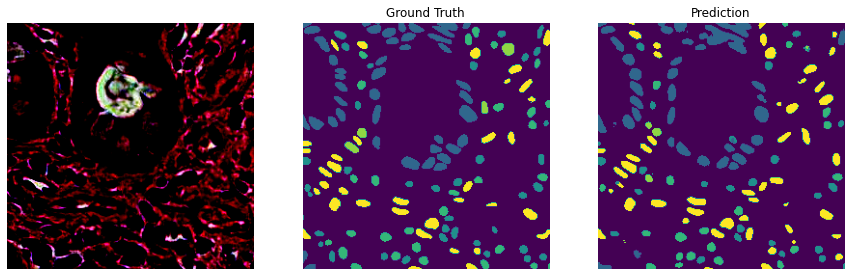

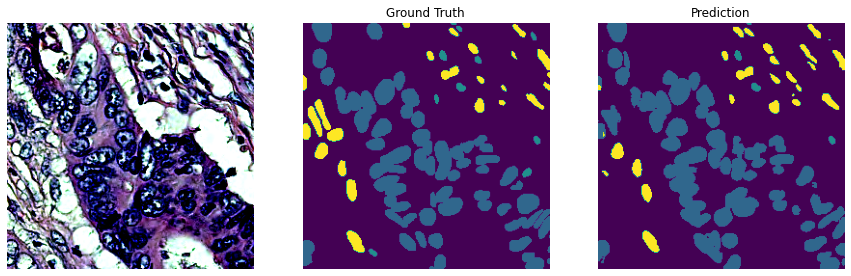

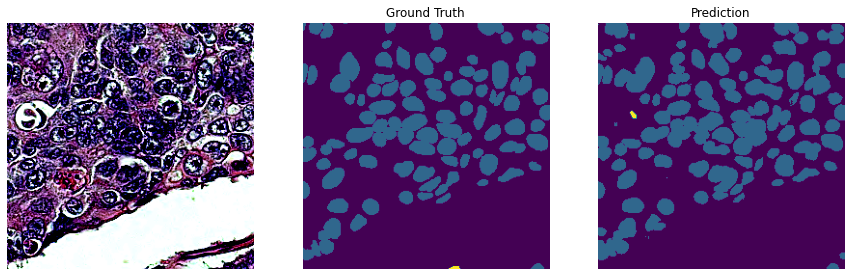

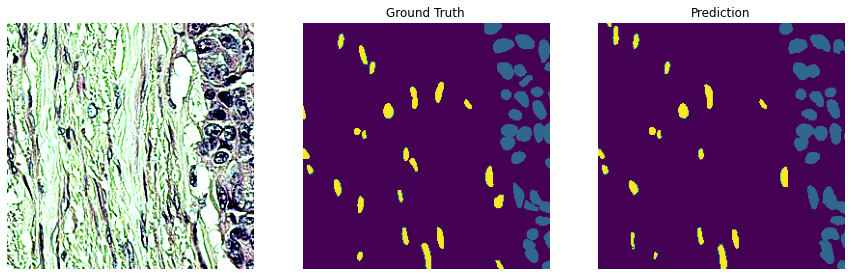

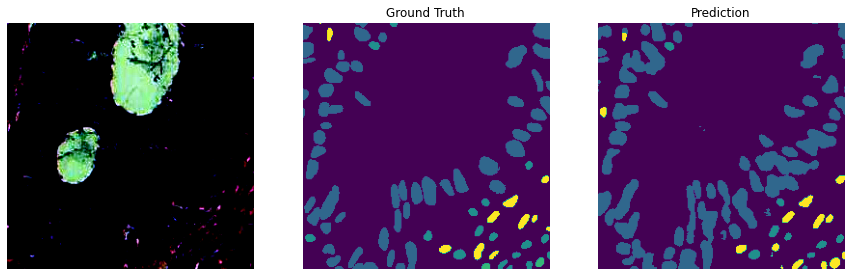

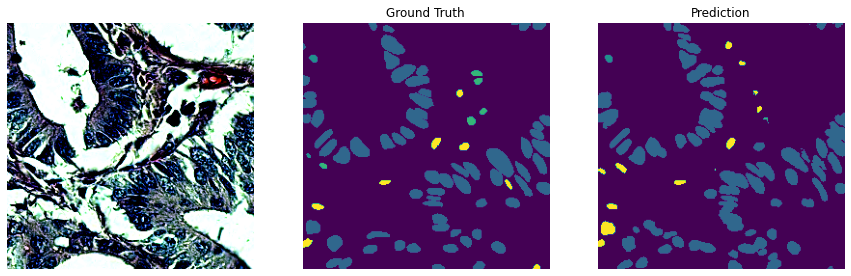

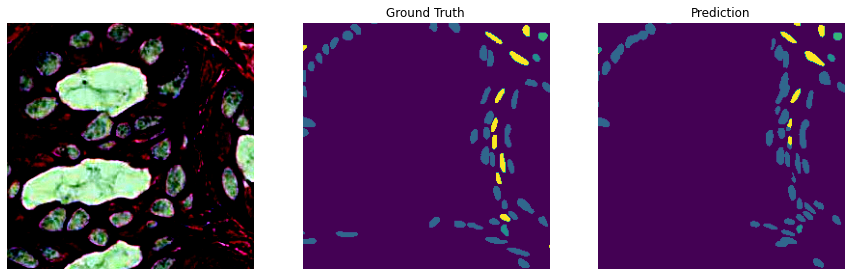

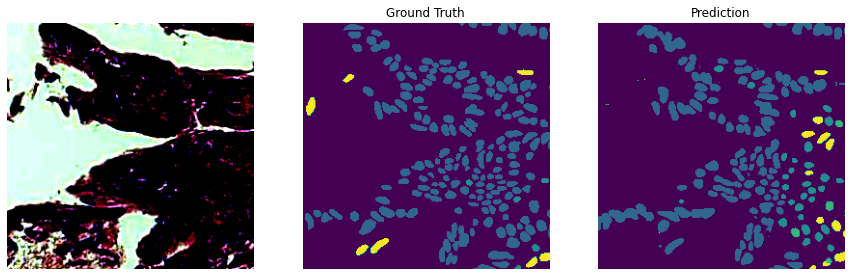

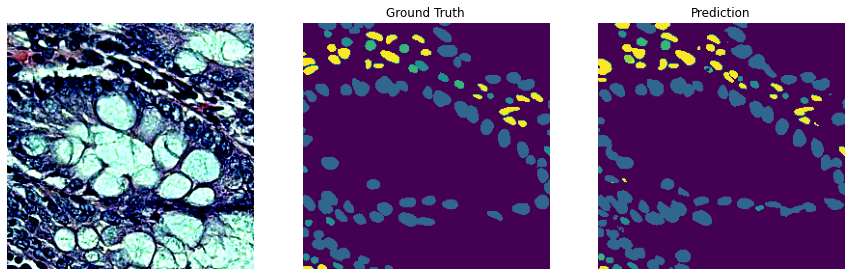

In [ ]:
predict_img(net,inputs, classes,device)

In [ ]:
print("The state dict keys: \n\n", net.state_dict().keys())

In [ ]:
# Save model
torch.save(net.state_dict(), "modelwithcrf.pth")

In [31]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('modelwithcrf.pth')

/kaggle/working


/kaggle/working/modelwithcrf.pth